# Skin Cancer Detection Powered by AI

## Introduction

Skin cancer is one of the most common types of cancer worldwide, and early detection is crucial for effective treatment and improved survival rates. This project leverages the power of Artificial Intelligence (AI) and deep learning to build a robust system for detecting skin cancer from dermoscopic images. By analyzing images of skin lesions, the model can classify them as benign or malignant, aiding dermatologists in making accurate and timely diagnoses.

## Objectives

- To preprocess and analyze a dataset of skin lesion images and metadata.
- To build and train a deep learning model using transfer learning with MobileNetV2.
- To evaluate the model's performance using metrics such as accuracy, F1 score, and confusion matrix.
- To deploy the model using an interactive interface for real-time predictions.

## Dataset

The dataset used in this project is the HAM10000 dataset, which contains:
- **Images**: High-quality dermoscopic images of various skin lesions.
- **Metadata**: Information such as diagnosis type, patient age, sex, and lesion localization.

The dataset includes seven types of skin lesions:
- **akiec**: Actinic Keratoses and intraepithelial carcinoma
- **bcc**: Basal Cell Carcinoma
- **bkl**: Benign Keratosis-like Lesions
- **df**: Dermatofibroma
- **mel**: Melanoma
- **nv**: Melanocytic Nevi
- **vasc**: Vascular lesions

## Key Features

- **Data Preprocessing**: Handling missing values, balancing classes, and augmenting images to improve model performance.
- **Deep Learning Model**: A MobileNetV2-based architecture fine-tuned for binary classification (benign vs malignant).
- **Evaluation**: Comprehensive evaluation using metrics like accuracy, recall, and F1 score.
- **Deployment**: A user-friendly Gradio interface for real-time predictions.

This project demonstrates the potential of AI in healthcare, particularly in assisting medical professionals with early and accurate detection of skin cancer.

# Data Science and Data Loading

## Data Loading and Exploration

This section focuses on loading and exploring the HAM10000 dataset, which includes metadata and dermoscopic images of skin lesions. The dataset is analyzed to understand its structure, distribution, and key features, which are critical for building a robust AI model for skin cancer detection.

In [175]:
# Importing necessary libraries 

import pandas as pd
import numpy as np, cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
from PIL import Image
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from glob import glob
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import shutil
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
import gradio as gr
from tensorflow.keras.preprocessing import image



In [176]:
csv = 'HAM10000_metadata.csv'     # CVS path
dx_metadata = pd.read_csv(csv)    # raeding csv 
dx_metadata = pd.DataFrame(dx_metadata) 
dx_metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [177]:
# Columns Values count for handdle data invalance

dx_table = (
    dx_metadata["dx"]
      .value_counts()                      # Series
      .rename_axis("Diagnosis")            # name the index
      .reset_index(name="Count")           # DataFrame with columns ["Diagnosis","Count"]
)
display(dx_table)


,Diagnosis,Count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


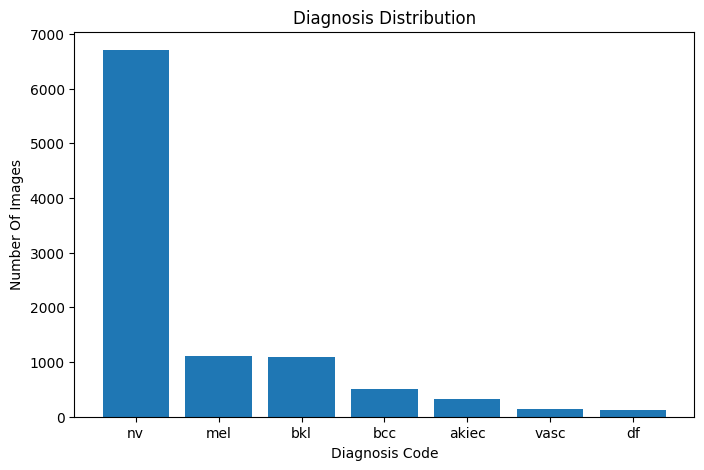

"\nThe HAM10000 dataset contains images of various skin lesion types, but the distribution of these diagnoses is highly imbalanced.\nFor example, the 'nv' (melanocytic nevi) class has far more samples than rare classes like 'df' (dermatofibroma) or 'vasc' (vascular lesions).\nThis imbalance can affect model training, causing it to favor the majority classes and potentially reducing accuracy for minority classes.\nIt's important to visualize and address this imbalance to ensure the model performs well across all diagnosis categories.\n"

In [178]:
# Plotting the distribution of the top diagnoses in the 'dx' column

plt.figure(figsize=(8,5))
plt.bar(dx_table['Diagnosis'], dx_table['Count'])
plt.xlabel('Diagnosis Code')
plt.ylabel('Number Of Images')
plt.title('Diagnosis Distribution')
plt.show()

'''
The HAM10000 dataset contains images of various skin lesion types, but the distribution of these diagnoses is highly imbalanced.
For example, the 'nv' (melanocytic nevi) class has far more samples than rare classes like 'df' (dermatofibroma) or 'vasc' (vascular lesions).
This imbalance can affect model training, causing it to favor the majority classes and potentially reducing accuracy for minority classes.
It's important to visualize and address this imbalance to ensure the model performs well across all diagnosis categories.
'''

# Comparative Table of Cancer Types (Benign vs Malignant)

This table provides a comparison of the number of benign and malignant cases for each type of cancer in the dataset.

| Cancer Type | Benign | Malignant | 
|-------------|--------|-----------|
| akiec       |    0   |    327    | 
| bcc         |    0   |    514    | 
| bkl         |  1099  |     0     | 
| df          |   115  |     0     | 
| mel         |    0   |   1113    | 
| nv          |  6705  |     0     | 
| vasc        |   142  |     0     | 

- **Benign**: Number of benign cases for each cancer type.
- **Malignant**: Number of malignant cases for each cancer type.
- **Total**: Total number of cases for each cancer type.

This table helps in understanding the distribution of benign and malignant cases across different cancer types in the dataset.

### Diagnosis Labels Connected with `dx` Column:

- **akiec**: Actinic Keratoses and intraepithelial carcinoma  
- **bcc**: Basal Cell Carcinoma  
- **bkl**: Benign Keratosis-like Lesions  
- **df**: Dermatofibroma  
- **mel**: Melanoma  
- **nv**: Melanocytic Nevi  
- **vasc**: Vascular lesions


In [179]:
# Checking for missing values 
print('Null Values:')
print(dx_metadata.isnull().sum())     # It’s better to drop nulls in our age column for better quality, given how important it is.

print("\nUnique sex values:")
print(dx_metadata['sex'].unique())

print("\nSex value counts:")
print(dx_metadata['sex'].value_counts())  

Null Values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Unique sex values:
['male' 'female' 'unknown']

Sex value counts:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


# Data Cleaning: Removing Unknown Labels

In this step, we removed entries with the label "unknown" because they provided irrelevant information. 
These entries were categorized under the "benign" label, and their removal does not significantly impact the dataset's integrity. 
By excluding this data, we ensure that the remaining dataset is more reliable and focused on meaningful information for training the model.

In [180]:
# Droping unknow label 
dx_metadata_cl = dx_metadata.dropna()
dx_metadata_cl = dx_metadata_cl[dx_metadata_cl['sex'] != 'unknown']

In [181]:
# Calculate and display the distribution of patient ages in the dataset.

dx_table_age = (
    dx_metadata_cl['age']
      .value_counts()
      .rename_axis('Age')
      .reset_index(name='Count')
)

display(dx_table_age)

,Age,Count
0,45.0,1297
1,50.0,1187
2,55.0,1009
3,40.0,985
4,60.0,800
5,70.0,756
6,35.0,750
7,65.0,731
8,75.0,618
9,30.0,464


### Age and Malignancy Rate Relationship

As observed in the previous analysis, the proportion of malignant skin lesions increases with age. 
The grouped data and bar plot show that older age groups have a higher rate of malignancy compared to younger groups. 
For example, individuals in the "81+" age group have a much higher malignant lesion rate than those in the "0-20" group. 
This trend highlights the importance of age as a risk factor for skin cancer, emphasizing the need for increased vigilance and screening in older populations.

In [ ]:
# Malignant diagnosis codes
malignat_code = ['mel', 'bcc', 'akiec']

# Add binary label for malignancy
dx_metadata_cl['is_malignant'] = dx_metadata_cl['dx'].isin(malignat_code)
print(dx_metadata_cl[["dx","is_malignant"]].drop_duplicates().sort_values("dx"))


         dx  is_malignant
9687  akiec          True
2462    bcc          True
0       bkl         False
1095     df         False
1211    mel          True
64       nv         False
2320   vasc         False


In [183]:
bins = [0, 20, 40, 60, 80, 120]
labels = ['0-20', '21-40', '41-60', '61-80', '81+'] # ---> Labeling + Bining

# Creating Age Group column 
dx_metadata_cl ['age_group'] = pd.cut(dx_metadata_cl['age'], bins=bins, labels=labels, right=False)

print(dx_metadata_cl['age_group'].value_counts().sort_index())

age_group
0-20      241
21-40    1630
41-60    4478
61-80    2905
81+       694
Name: count, dtype: int64


In [184]:
# Creating samlkl the set for or new columns that can see witch patients are critical to contage cancer cause they age rank. 

grouped = (
    dx_metadata_cl 
    .groupby(["age_group","is_malignant"])
    .size()
    .unstack(fill_value=0)
)

# total images per bin
grouped["total"] = grouped.sum(axis=1)

# malignant rate = malignant / total
grouped["malignant_rate"] = grouped[True] / grouped["total"]

print(grouped[["total","malignant_rate"]])


is_malignant  total  malignant_rate
age_group                          
0-20            241        0.004149
21-40          1630        0.065031
41-60          4478        0.117686
61-80          2905        0.333907
81+             694        0.501441


/var/folders/sn/83_04zmn3dgf5s366ldfm1lr0000gn/T/ipykernel_51260/192950831.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group","is_malignant"])


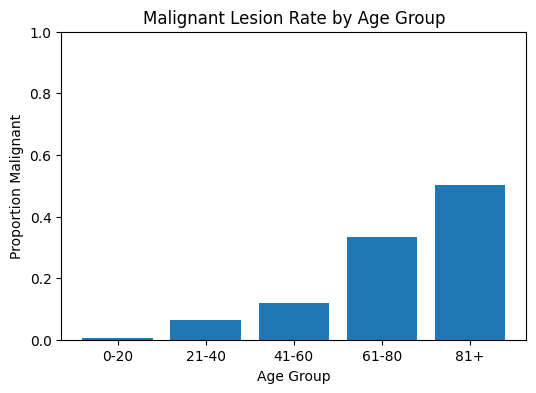

In [185]:
plt.figure(figsize=(6,4))
plt.bar(grouped.index.astype(str), grouped["malignant_rate"])
plt.xlabel("Age Group")
plt.ylabel("Proportion Malignant")
plt.title("Malignant Lesion Rate by Age Group")
plt.ylim(0,1)
plt.show()


In [186]:
# Compare malignancy rates by sex
sex_malignancy = pd.crosstab(dx_metadata_cl['sex'], dx_metadata_cl['is_malignant'])
print(f'\nCalculation of witch sex has hight risc os get sking cancer :\n{sex_malignancy}')


Calculation of witch sex has hight risc os get sking cancer :
is_malignant  False  True 
sex                       
female         3821    727
male           4175   1225


In [187]:
# Calculate the proportion of malignant cases for each sex
sex_malignancy['malignancy_rate'] = sex_malignancy[True] / (sex_malignancy[True] + sex_malignancy[False])
print("\nMalignancy rate by sex:")
print(sex_malignancy['malignancy_rate'])


Malignancy rate by sex:
sex
female    0.159850
male      0.226852
Name: malignancy_rate, dtype: float64


In [188]:
# Map precomputed malignancy rates to each sex
malignancy_rates = {
    'female': 0.15971,
    'male': 0.22697
}

dx_metadata_cl['sex_malignacy_rate'] = dx_metadata_cl['sex'].map(malignancy_rates)

In [189]:
# Calculate frequency of each diagnosis type and map to the dataset
dx_counts = dx_metadata_cl['dx'].value_counts()
dx_metadata_cl = dx_metadata_cl.copy()
dx_metadata_cl['dx_frequency'] = dx_metadata_cl['dx'].map(dx_counts)

In [190]:
# Convert age column to integer type for consistency
dx_metadata_cl['age'] = dx_metadata_cl['age'].astype(int)

In [191]:
display(dx_metadata_cl)

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_malignant,age_group,sex_malignacy_rate,dx_frequency
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,False,81+,0.22697,1089
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,False,81+,0.22697,1089
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,False,81+,0.22697,1089
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,False,81+,0.22697,1089
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,False,61-80,0.22697,1089
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40,male,abdomen,True,41-60,0.22697,327
10011,HAM_0002867,ISIC_0033550,akiec,histo,40,male,abdomen,True,41-60,0.22697,327
10012,HAM_0002867,ISIC_0033536,akiec,histo,40,male,abdomen,True,41-60,0.22697,327
10013,HAM_0000239,ISIC_0032854,akiec,histo,80,male,face,True,81+,0.22697,327


In [192]:
# Convert malignancy labels to integer list for modeling
labels = dx_metadata_cl["is_malignant"].astype(int).tolist()
print('Value counts:', dx_metadata_cl['is_malignant'].value_counts())

Value counts: is_malignant
False    7996
True     1952
Name: count, dtype: int64


# Image Processing for Skin Lesion Analysis

In [193]:
ROOT = "/Users/andreslinero/Desktop/Fullstack/Cancer Detection powered by AI"

In [194]:
# Creating path for conect directires and files with the notebook 

image_folders = [
    os.path.join(ROOT, 'HAM10000_images_part_1'),
    os.path.join(ROOT, 'HAM10000_images_part_2')
]

for folder in image_folders:
    if os.path.exists(folder):
        print(f'Image Folder Found:{os.path.basename(folder)}')
    else:
        print(f'File Not Found: {folder}')

Image Folder Found:HAM10000_images_part_1
Image Folder Found:HAM10000_images_part_2


In [195]:
# Collect all image paths
all_image_paths = []
for folder in image_folders:
    if os.path.exists(folder):
        images = glob(os.path.join(folder, "*.jpg"))
        all_image_paths.extend(images)
        print(f"Found {len(images)} images in {os.path.basename(folder)}")

print(f"\nTotal images found: {len(all_image_paths)}")



Found 5000 images in HAM10000_images_part_1
Found 5015 images in HAM10000_images_part_2

Total images found: 10015


In [196]:
image_dict = {}
for path in all_image_paths:
    # Extract just the ID (e.g., "ISIC_0027419")
    image_id = os.path.splitext(os.path.basename(path))[0]
    image_dict[image_id] = path

print(f"Created dictionary with {len(image_dict)} unique image IDs")


Created dictionary with 10015 unique image IDs


In [197]:
# Check how many images were found
print(f"Total images in all_image_paths: {len(all_image_paths)}")

# Show the first 5 paths to see what they look like
print("\nFirst 5 image paths:")
for i, path in enumerate(all_image_paths[:5]):
    print(f"  {i+1}. {path}")

# Check the file names specifically
print("\nFirst 5 image names (without path):")
for i, path in enumerate(all_image_paths[:5]):
    filename = os.path.basename(path)
    print(f"  {i+1}. {filename}")

Total images in all_image_paths: 10015

First 5 image paths:
  1. /Users/andreslinero/Desktop/Fullstack/Cancer Detection powered by AI/HAM10000_images_part_1/ISIC_0026784.jpg
  2. /Users/andreslinero/Desktop/Fullstack/Cancer Detection powered by AI/HAM10000_images_part_1/ISIC_0028971.jpg
  3. /Users/andreslinero/Desktop/Fullstack/Cancer Detection powered by AI/HAM10000_images_part_1/ISIC_0026948.jpg
  4. /Users/andreslinero/Desktop/Fullstack/Cancer Detection powered by AI/HAM10000_images_part_1/ISIC_0026790.jpg
  5. /Users/andreslinero/Desktop/Fullstack/Cancer Detection powered by AI/HAM10000_images_part_1/ISIC_0028965.jpg

First 5 image names (without path):
  1. ISIC_0026784.jpg
  2. ISIC_0028971.jpg
  3. ISIC_0026948.jpg
  4. ISIC_0026790.jpg
  5. ISIC_0028965.jpg


In [198]:
# Check what the CSV image_ids look like
print("First 5 image_ids from CSV:")
print(dx_metadata_cl['image_id'].head(5).tolist())

# Check if there's any whitespace or formatting issues
first_csv_id = dx_metadata_cl['image_id'].iloc[0]
print(f"\nFirst CSV image_id: '{first_csv_id}'")
print(f"Length: {len(first_csv_id)}")

# Check if this ID exists in our dictionary
if first_csv_id in image_dict:
    print(f"Found {first_csv_id} in image_dict!")
else:
    print(f"{first_csv_id} NOT found in image_dict")
    
    # Finding similar keys
    similar = [key for key in image_dict.keys() if first_csv_id in key or key in first_csv_id]
    if similar:
        print(f"   Similar keys found: {similar}")

First 5 image_ids from CSV:
['ISIC_0027419', 'ISIC_0025030', 'ISIC_0026769', 'ISIC_0025661', 'ISIC_0031633']

First CSV image_id: 'ISIC_0027419'
Length: 12
Found ISIC_0027419 in image_dict!


In [199]:
dx_metadata_cl['has_image'] = dx_metadata_cl['image_id'].isin(image_dict.keys())

# Checking the results

print(f"\nMatching Results:")
print(f"   Images WITH metadata: {dx_metadata_cl['has_image'].sum()}")
print(f"   Images WITHOUT metadata: {(~dx_metadata_cl['has_image']).sum()}")


Matching Results:
   Images WITH metadata: 9948
   Images WITHOUT metadata: 0


In [200]:
# Show examples of matched images and their diagnosis
matched_examples = dx_metadata_cl[dx_metadata_cl['has_image']].head(3)
print(f"\nExamples of matched images:")
for _, row in matched_examples.iterrows():
    print(f"   {row['image_id']} -> Diagnosis: {row['dx']}")


Examples of matched images:
   ISIC_0027419 -> Diagnosis: bkl
   ISIC_0025030 -> Diagnosis: bkl
   ISIC_0026769 -> Diagnosis: bkl


In [201]:
# Add the image_path column using the image_dict we created earlier
if 'image_path' not in dx_metadata_cl.columns:
    # Map image_id to image_path
    dx_metadata_cl['image_path'] = dx_metadata_cl['image_id'].map(image_dict)
    print("\nAdded image_path column!")
else:
    print("\nimage_path column already exists!")

print("\nChecking image paths:")
print(dx_metadata_cl[['image_id', 'image_path']].head(3))

# Check how many paths are valid (not NaN)
valid_paths = dx_metadata_cl['image_path'].notna().sum()
print(f"\nValid image paths: {valid_paths} out of {len(dx_metadata_cl)}")


Added image_path column!

Checking image paths:
       image_id                                         image_path
0  ISIC_0027419  /Users/andreslinero/Desktop/Fullstack/Cancer D...
1  ISIC_0025030  /Users/andreslinero/Desktop/Fullstack/Cancer D...
2  ISIC_0026769  /Users/andreslinero/Desktop/Fullstack/Cancer D...

Valid image paths: 9948 out of 9948


In [202]:
# creating Final Data Set after applying future inginieering and image proccessing 

final_df = dx_metadata_cl[dx_metadata_cl['has_image']== True ].copy()

print('Final DataSet:')
display(final_df)

Final DataSet:


,lesion_id,image_id,dx,dx_type,age,sex,localization,is_malignant,age_group,sex_malignacy_rate,dx_frequency,has_image,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,False,81+,0.22697,1089,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,False,81+,0.22697,1089,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,False,81+,0.22697,1089,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,False,81+,0.22697,1089,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,False,61-80,0.22697,1089,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40,male,abdomen,True,41-60,0.22697,327,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40,male,abdomen,True,41-60,0.22697,327,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40,male,abdomen,True,41-60,0.22697,327,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80,male,face,True,81+,0.22697,327,True,/Users/andreslinero/Desktop/Fullstack/Cancer D...


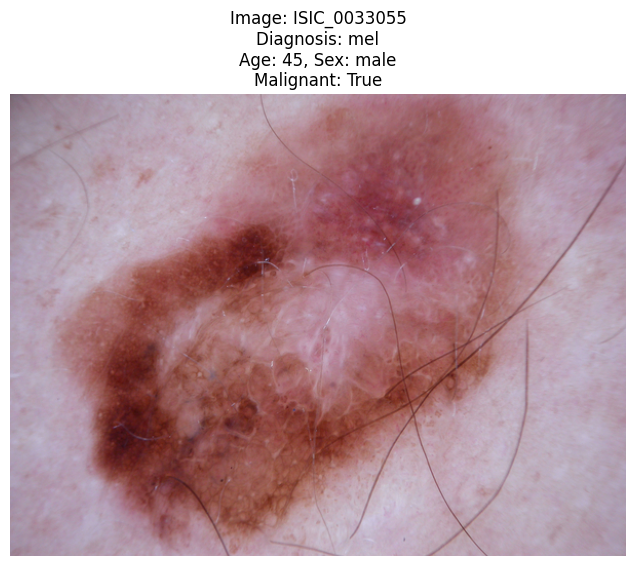

Image loaded successfully!
   Size: (600, 450)
   Mode: RGB


In [203]:
# Pick a random row
test_row = final_df.sample(1).iloc[0]

# Load and display the image
img = Image.open(test_row['image_path'])

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"Image: {test_row['image_id']}\n"
          f"Diagnosis: {test_row['dx']}\n"
          f"Age: {test_row['age']}, Sex: {test_row['sex']}\n"
          f"Malignant: {test_row['is_malignant']}")
plt.axis('off')
plt.show()

print(f"Image loaded successfully!")
print(f"   Size: {img.size}")
print(f"   Mode: {img.mode}")

# Preparing Images for Training with MobileNetV2

1. **Image Resizing**: Resize all images to `(224, 224, 3)` for MobileNetV2 compatibility.
2. **Normalization**: Normalize pixel values or use MobileNetV2's preprocessing function.
3. **Data Augmentation**: Apply techniques like rotation, flipping, zooming, and brightness adjustments.
4. **Batch Preparation**: Use `ImageDataGenerator` or `image_dataset_from_directory` for batching.
5. **Label Encoding**: Convert labels to binary format (`0` for benign, `1` for malignant).
6. **Dataset Splitting**: Split into training, validation, and test sets.

These steps ensure the dataset is optimized for effective training with MobileNetV2.


In [204]:
# Function to load and preprocess a single image for MobileNetV2 input
IMG_SIZE = (224, 224)

def load_prrocess_one(path):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)
    img = preprocess_input(img)  
    return img


In [205]:
# Get unique lesion IDs and shuffle for train/val/test split
unique_lesions = final_df["lesion_id"].unique()
print("Unique lesions:", len(unique_lesions))

np.random.seed(42)
np.random.shuffle(unique_lesions)

Unique lesions: 7414


In [206]:
# Split unique lesions into train, validation, and test sets
n = len(unique_lesions)

train_lesions = unique_lesions[:int(n * 0.7)]
val_lesions   = unique_lesions[int(n * 0.7):int(n * 0.85)]
test_lesions  = unique_lesions[int(n * 0.85):]

In [207]:
# Create train, validation, and test DataFrames using lesion splits
train_df = final_df[final_df["lesion_id"].isin(train_lesions)].copy()
val_df   = final_df[final_df["lesion_id"].isin(val_lesions)].copy()
test_df  = final_df[final_df["lesion_id"].isin(test_lesions)].copy()


In [208]:
# Creating a small training batch and preprocess images and labels
N = 64
X_small, y_small = [], []

for _, row in train_df.iloc[:N].iterrows():
    img = load_preprocess_one(row["image_path"])
    if img is None:
        continue
    X_small.append(img)
    y_small.append(int(row["is_malignant"]))

X_small = np.stack(X_small)
y_small = np.array(y_small)

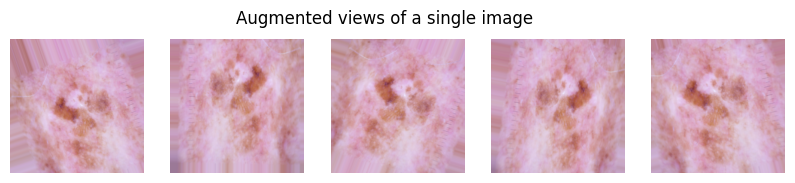

In [209]:
# Image data augmentation and visualization of augmented samples
datagen = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    zoom_range=0.1,           
    horizontal_flip=True,    
)

datagen.fit(X_small)

img = X_small[0].reshape((1, 224, 224, 3))

aug_iter = datagen.flow(img, batch_size=1)

# Plot 5 versions of the augmented image
plt.figure(figsize=(10, 2))
for i in range(5):
    aug_img = next(aug_iter)[0]
    plt.subplot(1, 5, i+1)
    plt.imshow((aug_img + 1) / 2)  
    plt.axis('off')
plt.suptitle("Augmented views of a single image")
plt.show()



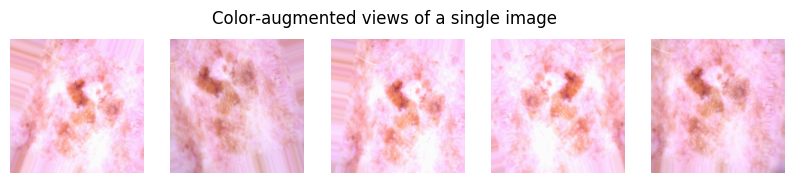

In [210]:
datagen_color = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],  # darker to brighter
)

img = X_small[0].reshape((1, 224, 224, 3))

aug_iter_color = datagen_color.flow(img, batch_size=1)

plt.figure(figsize=(10, 2))
for i in range(5):
    aug_img = next(aug_iter_color)[0]
    plt.subplot(1, 5, i+1)
    plt.imshow((aug_img + 1) / 2)
    plt.axis('off')
plt.suptitle("Color‑augmented views of a single image")
plt.show()


In [211]:
# Data augmentation pipeline for training images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2)
])

# Model Architecture and Fine-Tuning

## Model Structure

The model leverages **MobileNetV2** pre-trained on **ImageNet** for binary classification (benign vs malignant). Key components:
1. **Base Model**: MobileNetV2 as a frozen feature extractor.
2. **Data Augmentation**: Random flips, rotations, and zooms.
3. **Global Average Pooling**: Reduces feature map dimensions.
4. **Dense Layers**: 
    - 128 neurons with ReLU activation.
    - Dropout (rate: 0.3) for regularization.
5. **Output Layer**: Sigmoid activation for binary output.

## Fine-Tuning

Unfreeze top layers of the base model and train with a lower learning rate (1e-5) to adapt to the dataset.

## Training Details

- **Loss**: Binary Cross-Entropy
- **Optimizer**: Adam
- **Metrics**: Accuracy
- **Class Weights**: Handle class imbalance
- **Callbacks**:
  - Early Stopping
  - ReduceLROnPlateau

This architecture balances efficiency and accuracy for real-time skin cancer detection.


In [212]:
base_model = MobileNetV2(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)
base_model.trainable = False 

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  


In [213]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [214]:
#Fiting Model

history = model.fit(
    X_small,
    y_small,
    epochs=5,
    batch_size=16,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.8007 - loss: 0.4750 - val_accuracy: 1.0000 - val_loss: 0.1278
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9714 - loss: 0.2173 - val_accuracy: 1.0000 - val_loss: 0.0480
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0824 - val_accuracy: 1.0000 - val_loss: 0.0214
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0402 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 1.0000 - val_loss: 0.0071


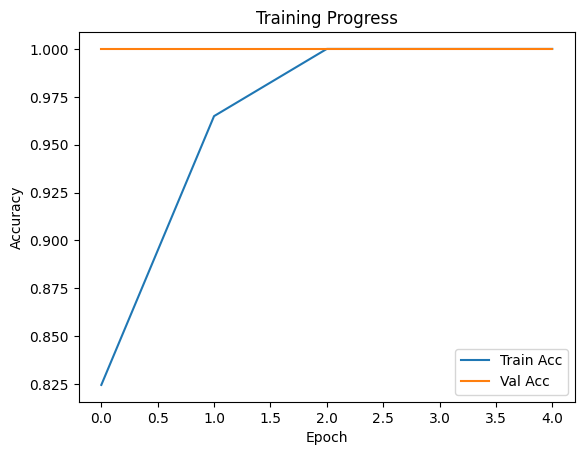

In [215]:
# Ploting our Accuracy curve 

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


###  Dataset Preparation

We create a structured folder system (`train/`, `val/`, `test/` with `benign/` and `malignant/` subfolders) to organize the images for loading with `image_dataset_from_directory`. 

This step ensures our model can correctly load and label images during training, validation, and testing.


In [216]:
BASE_DIR = "/Users/andreslinero/Desktop/Fullstack/CancerDataset"

# Create folder structure
for split in ["train", "val", "test"]:
    for label in ["benign", "malignant"]:
        os.makedirs(os.path.join(BASE_DIR, split, label), exist_ok=True)

# Helper function to copy files
def copy_images(df, split):
    for _, row in df.iterrows():
        src = row["image_path"]
        label = "malignant" if row["is_malignant"] else "benign"
        dst = os.path.join(BASE_DIR, split, label, os.path.basename(src))
        
        try:
            shutil.copyfile(src, dst)
        except Exception as e:
            print(f"Failed to copy: {src} --> {dst}")
            print("Error:", e)

# Copy images from each DataFrame
copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")

print("All images copied successfully into CancerDataset/")

All images copied successfully into CancerDataset/


In [217]:
train_ds = image_dataset_from_directory(
    BASE_DIR + "/train",
    label_mode="binary",
    image_size=(224, 224),
    batch_size=32,
    seed=42
)

val_ds = image_dataset_from_directory(
    BASE_DIR + "/val",
    label_mode="binary",
    image_size=(224, 224),
    batch_size=32,
    seed=42
)

test_ds = image_dataset_from_directory(
    BASE_DIR + "/test",
    label_mode="binary",
    image_size=(224, 224),
    batch_size=32,
    seed=42
)

Found 6972 files belonging to 2 classes.
Found 1509 files belonging to 2 classes.
Found 1467 files belonging to 2 classes.


In [218]:
# Extracting Labels from Training Set

train_labels = []

for images, labels in train_ds:
    train_labels.extend(labels.numpy().flatten())

train_labels = np.array(train_labels).astype(int)

In [219]:
# Applying class Weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights_dict
)

Class weights: {0: 0.6198435277382646, 1: 2.586053412462908}
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 255ms/step - accuracy: 0.5661 - loss: 0.9401 - val_accuracy: 0.5447 - val_loss: 0.7127
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.5703 - loss: 0.6905 - val_accuracy: 0.5726 - val_loss: 0.6991
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 62s 284ms/step - accuracy: 0.5880 - loss: 0.6777 - val_accuracy: 0.6190 - val_loss: 0.6675
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 68s 309ms/step - accuracy: 0.6110 - loss: 0.6533 - val_accuracy: 0.6812 - val_loss: 0.6284
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 332ms/step - accuracy: 0.6231 - loss: 0.6474 - val_accuracy: 0.6667 - val_loss: 0.6306
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - accuracy: 0.6299 - loss: 0.6339 - val_accuracy: 0.6726 - val_loss: 0.6240
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 78s 355ms/step - accuracy: 0.6506 - loss: 0.6276 - val_accuracy: 0.6302 - val_loss: 0.6502
Epoch 8/10
218/218 ━━━

In [220]:
model.evaluate(test_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 392ms/step - accuracy: 0.6362 - loss: 0.6475


[0.638524055480957, 0.6380367875099182]

In [221]:
# Collect true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.round(preds).numpy().astype(int).flatten()  # convert probabilities to 0 or s1
    y_pred.extend(preds)
    y_true.extend(labels.numpy().astype(int).flatten())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

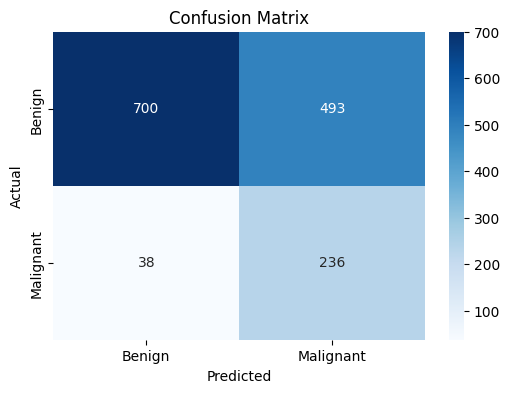

In [222]:
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## First Model Results 

The first CNN model shows promising results but is still **imbalanced in predictions**:  
- Correctly identified malignant cases (253), but also misclassified several benign ones.  
- This means the model is learning, but there’s room for improvement.  

### Key Takeaways:
- Model is **stable** as a baseline.  
- Next steps to improve:
  - Apply **Early Stopping** to prevent overfitting.  
  - Use **Data Augmentation** to provide more diverse training examples.  
  - Try **Transfer Learning** with pretrained CNNs (e.g., MobileNet, ResNet).  
  - Tune **hyperparameters** for better accuracy and recall.


In [223]:
# base_model_trainable = True 

# for layer in base_model.layers[:100]:
#     layer.trainable = False

# model.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

In [224]:
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=2,
#     verbose=1,
#     min_lr=1e-7
# )

In [225]:
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     class_weight=class_weights_dict,
#     callbacks=[lr_scheduler]
# )


In [226]:
# # 1. Unfreeze top layers of the base model
# base_model.trainable = True

# # 2. Freeze the first N layers (usually all except the top 20–30 layers)
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

# # 3. Compile again (important!)
# model.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # 4. Train again
# history_finetune = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,  # or more if time allows
#     class_weight=class_weights_dict,
# )


In [227]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
# ]

# history_finetune = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     class_weight=class_weights_dict,
#     callbacks=callbacks
# )

In [228]:
# y_pred_probs = model.predict(test_ds)
# y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# y_true = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)

# f1 = f1_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)

# print("F1 Score:", f1)
# print("Recall:", recall)


In [229]:
# print("Classification Report:\n")
# print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


# print("\nF1 Score:", f1)
# print("Recall:", recall)


In [230]:
# cm = confusion_matrix(y_true, y_pred)

# # Plot it
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

## Model Optimization Attempts 

We applied several optimization techniques to improve the model’s performance:  
- **Early Stopping** → to avoid overfitting.  
- **Learning Rate Scheduler** → to fine-tune training.  
- **Class Weights** → to balance benign vs malignant cases.  
- **Transfer Learning (freezing/unfreezing layers)** → to leverage pretrained features.  # ---> Because of MobileNetV2

### Outcome:
Despite these improvements, the optimized versions did **not outperform the first baseline model**.  
- Metrics like accuracy, recall, and F1-score remained similar.  
- The first model stayed more **stable** in predictions.  



In [231]:
model.save('Cancer_Detection_AI.keras')

In [232]:
model = load_model('Cancer_Detection_AI.keras')

In [233]:
class_names = ['Benign', 'Malignat']

def predict_skin_lesion(img):
    img = img.resize((224, 224))  # Ensure correct shape
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)[0][0]
    label = class_names[1] if prediction > 0.5 else class_names[0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return f"Prediction: {label} ({confidence:.2%} confidence)"


In [234]:
gr.Interface(
    fn=predict_skin_lesion,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Skin Cancer Detection (Benign vs Malignant)",
    description="Upload a skin lesion image to detect if it's likely benign or malignant using a deep learning model."
).launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


## Reflection on Model Performance 📝

The dataset imbalance strongly affected accuracy.  
I used **MobileNetV2** for efficiency on limited hardware, but the model still struggled and could not surpass the first baseline.  
Predictions remain inconsistent.


## Images are attcahed in canvas with this project.